In [ ]:
# default_exp engine.gmm_loss

In [ ]:
%load_ext autoreload
%autoreload 2

# Loss function

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution
from torch.distributions.utils import _sum_rightmost
from einops import rearrange
import torch.tensor as T
import torch.nn.functional as F

In [ ]:
#export
def ext_log_prob(mix, x):
    
    x = mix._pad(x)
    log_prob_x = mix.component_distribution.base_dist.log_prob(x) 
    log_prob_x = _sum_rightmost(log_prob_x, 1)
    
    log_mix_prob = torch.log_softmax(mix.mixture_distribution.logits, dim=-1)  
    return log_prob_x, log_mix_prob

In [ ]:
#export
class PointProcessGaussian(Distribution):
    def __init__(self, logits, xyzi_mu, xyzi_sigma, int_logits=None, **kwargs):
        """ Defines our loss function. Given logits, xyzi_mu and xyzi_sigma 
        
        The count loss first constructs a Gaussian approximation to the predicted number of emitters by summing the mean and the variance of the Bernoulli detection probability map,
        and then maximizes the probability of the true number of emitters under this distribution. 
        The localization loss models the distribution of sub-pixel localizations with a coordinate-wise independent Gaussian probability distribution  with a 3D standard deviation. 
        For imprecise localizations, this probability is maximized for large sigmas, for precise localizations for small sigmas. 
        The distribution of all localizations over the entire image is approximated as a weighted average of individual localization distributions, where the weights correspond to the probability of detection.
        
        Args (Network outputs):
            logits: shape (B,1,D,H,W)
            xyzi_mu: shape (B,4,D,H,W)
            xyzi_sigma: shape (B,4,D,H,W)
        """
        self.logits = logits.cuda()
        self.xyzi_mu = xyzi_mu.cuda()
        self.xyzi_sigma = xyzi_sigma.cuda()
        
    def log_prob(self, locations, x_offset, y_offset, z_offset, intensities, codes, n_bits, channels, loss_option=0, count_mult=0, cat_logits=0, slice_rec=False):
        
        gauss_dim = 3 + 1
        batch_size = self.logits.shape[0]
        n_codes = self.logits.shape[1]

        xyzi, gt_codes, s_mask = get_true_labels_mf(batch_size, locations, x_offset, y_offset, z_offset, intensities, codes.cuda(), slice_rec)

        P = torch.sigmoid(self.logits) 

        if loss_option == 0:
            # Calculate count loss individually for each code
            count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
            count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
            count_dist = D.Normal(count_mean, torch.sqrt(count_var))

            counts = torch.zeros(count_mean.shape).cuda()
            unique_col = [gtc.unique(return_counts=True) for gtc in gt_codes]
            for i, ind_c in enumerate(unique_col):
                inds, c = ind_c
                counts[i, inds[inds>=0]] = c[inds>=0].type(torch.cuda.FloatTensor)

            count_prob =  count_dist.log_prob(counts)
            if count_mult:
                count_prob = count_prob * counts
            
            count_prob = count_prob.sum(-1) 
            
        if loss_option == 1:
            # Calculate count loss by summing over all code channels
            count_mean = P.sum(dim=[1, 2, 3, 4]).squeeze(-1)
            count_var = (P - P ** 2).sum(dim=[1, 2, 3, 4]).squeeze(-1) 
            count_dist = D.Normal(count_mean, torch.sqrt(count_var))

            counts = s_mask.sum(-1)
            count_prob =  count_dist.log_prob(counts) 
            if count_mult:
                count_prob = count_prob * counts

        pix_inds = torch.nonzero(P[:,:1],as_tuple=True)

        xyzi_mu = self.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
        if slice_rec: xyzi_mu[:,2] = 0.5*xyzi_mu[:,2] 
        # We squish the network output range in z to -0.25:0.25 beause for slice rec the true pixel inds are unqiue (i.e. cant point to the same point from different pixels)
        xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
        xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
        xyzi_sig = self.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)

        if cat_logits:
            mixture_probs = P / P.sum(dim=[2, 3, 4], keepdim=True)
            mix = D.Categorical(mixture_probs[torch.nonzero(P,as_tuple=True)].reshape(batch_size, n_codes, -1))
            mix_logits = mix.logits    
        else:
            mix_logits = self.logits[torch.nonzero(P,as_tuple=True)].reshape(batch_size, n_codes, -1)

        dist_normal_xyzi = D.Independent(D.Normal(xyzi_mu, xyzi_sig + 0.00001), 1)

        xyzi_inp = xyzi.transpose(0, 1)[:,:,None,:]          # reshape for log_prob()
        log_norm_prob_xyzi = dist_normal_xyzi.base_dist.log_prob(xyzi_inp) # N_gt * batch_size * n_pixel * 3

        if loss_option == 0:
            log_cat_prob = torch.log_softmax(mix_logits, -1) # + torch.log(counts+1e-6)[:, None]       # normalized (sum to 1 over pixels) log probs for the categorical dist. of the GMM. batch_size * n_pixels
        else:
            log_cat_prob = torch.log_softmax(mix_logits.view(batch_size, -1), -1).view(mix_logits.shape)

        gt_codes[gt_codes<0] = 0
        log_norm_prob_xyzi = _sum_rightmost(log_norm_prob_xyzi, 1)         # N_gt * batch_size * n_pixel
        total_prob = torch.logsumexp(log_norm_prob_xyzi + torch.gather(log_cat_prob, 1, gt_codes[...,None].expand(-1,-1,log_cat_prob.shape[-1])).transpose(0,1),-1).transpose(0, 1)

        total_prob = (total_prob * s_mask).sum(-1)  # s_mask: batch_size * N_gt. Binary mask to remove entries in all samples that have less then N_gt GT emitters.

        return count_prob, total_prob

def get_sample_mask(bs, locations):
    
    counts_ = torch.unique(locations[0], return_counts=True)[1]
    batch_loc = torch.unique(locations[0])
    
    counts = torch.cuda.LongTensor(bs).fill_(0)
    counts[batch_loc] = counts_
    
    max_counts = counts.max()
    if max_counts==0: max_counts = 1 #if all 0 will return empty matrix of correct size
    s_arr = cum_count_per_group(locations[0])
    s_mask   = torch.cuda.FloatTensor(bs,max_counts).fill_(0)
    s_mask[locations[0],s_arr] = 1   
    
    return s_mask, s_arr

def get_true_labels_mf(bs, locations, x_os, y_os, z_os, int_ch, codes, slice_rec):
    
    n_gt = len(x_os)
    
    s_mask, s_arr = get_sample_mask(bs, locations)
    max_counts = s_mask.shape[1]

    x =  x_os + locations[-1].type(torch.cuda.FloatTensor) + 0.5 
    y =  y_os + locations[-2].type(torch.cuda.FloatTensor) + 0.5 
    if slice_rec: z_os *= 0.5
    z =  z_os + locations[-3].type(torch.cuda.FloatTensor) + 0.5 
    
    loc_idx = torch.arange(n_gt).repeat_interleave(4)
    
    intensity = int_ch.sum(-1)
    
    gt_vars = torch.stack([x, y, z, intensity], dim=1)
    gt_list = torch.cuda.FloatTensor(bs,max_counts,gt_vars.shape[1]).fill_(0)
    gt_list[locations[0],s_arr] = gt_vars
    
    gt_codes = torch.cuda.LongTensor(bs,max_counts).fill_(0) - 1
    gt_codes[locations[0],s_arr] = codes
    
    return gt_list, gt_codes, s_mask  

def grp_range(counts: torch.Tensor):
    assert counts.dim() == 1

    idx = counts.cumsum(0)
    id_arr = torch.ones(idx[-1], dtype=int, device=counts.device)
    id_arr[0] = 0
    id_arr[idx[:-1]] = -counts[:-1] + 1
    return id_arr.cumsum(0)

def cum_count_per_group(arr):
    """
    Helper function that returns the cumulative sum per group.
    Example:
        [0, 0, 0, 1, 2, 2, 0] --> [0, 1, 2, 0, 0, 1, 3]
    """

    if arr.numel() == 0:
        return arr

    _, cnt = torch.unique(arr, return_counts=True)
    return grp_range(cnt)[np.argsort(np.argsort(arr.cpu().numpy(), kind='mergesort'), kind='mergesort')]

In [ ]:
# model_out = torch.load('../data/model_batch_output_code_int_p.pt')
# sim_vars = torch.load('../data/sim_var_code_int_p.pt')
model_out = torch.load('../data/model_batch_output_class3.pt')
sim_vars = torch.load('../data/sim_var_code_class3.pt')

In [ ]:
pix_inds = pix_inds = torch.nonzero(model_out['logits'][:,:1],as_tuple=True)
xyzi_mu = model_out['xyzi_mu'][pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
xyzi_mu[:,2] = 0.25*xyzi_mu[:,2]
xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
xyzi_mu = xyzi_mu.reshape(batch_size,-1,4)

In [ ]:
model_out['xyzi_mu'][:,2].max()

tensor(1., device='cuda:0')

In [ ]:
ppg = PointProcessGaussian(**model_out)
# ppg.log_prob(*sim_vars[:5], n_bits=4, channels=16, min_int_sig=1.0, int_fac=0)

In [ ]:
gt_codes = sim_vars[-1]
unique_col = gt_codes.unique(return_counts=True)

In [ ]:
locations, x_offset, y_offset, z_offset, intensities, output_shape, codes = sim_vars
batch_size = output_shape[0]
xyzi, gt_codes, s_mask = get_true_labels_mf(batch_size, locations, x_offset, y_offset, z_offset, intensities, codes.cuda(), True)

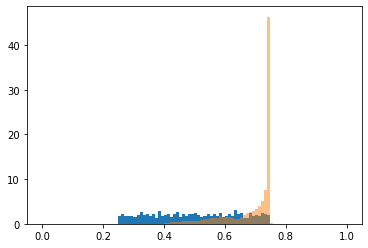

In [ ]:
plt.hist(cpu(xyzi)[1,:,2]%1, bins=np.linspace(0,1,101), density=True)
_=plt.hist(cpu(xyzi_mu)[1,:,2]%1, bins=np.linspace(0,1,101), alpha=0.5, density=True)

In [ ]:
(cpu(xyzi_mu)[1,:,2]%1).max()

0.7497835

In [ ]:
# ppg.log_prob(*sim_vars[:5], sim_vars[-1], n_bits=4, channels=16, loss_option=1)

In [ ]:
ppg.log_prob(*sim_vars[:5], sim_vars[-1], n_bits=4, channels=22, loss_option=0, count_mult=0, cat_logits=0)

(tensor([ 483.8336,  325.7159, -184.5045], device='cuda:0'),
 tensor([   0.6811,  -74.2657, -482.6904], device='cuda:0',
        grad_fn=<SumBackward1>))

In [ ]:
ppg.log_prob(*sim_vars[:5], sim_vars[-1], n_bits=4, channels=16, loss_option=1, count_mult=0, cat_logits=0)

In [ ]:
locations, x_offset, y_offset, z_offset, intensities = sim_vars[:5]
codes = sim_vars[-1]
n_bits=4; channels=16; min_int_sig=1.; int_fac=16
old_loss = False

In [ ]:
loss_option = 1
count_mult = 0
cat_logits = 1

In [ ]:
gauss_dim = 3 + 1
batch_size = ppg.logits.shape[0]

xyzi, gt_codes, s_mask = get_true_labels_mf(batch_size, locations, x_offset, y_offset, z_offset, intensities, codes.cuda())

P = torch.sigmoid(ppg.logits) 

if loss_option == 0:
    
    count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
    count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
    count_dist = D.Normal(count_mean, torch.sqrt(count_var))

    counts = torch.zeros(count_mean.shape).cuda()
    unique_col = [gtc.unique(return_counts=True) for gtc in gt_codes]
    for i, ind_c in enumerate(unique_col):
        inds, c = ind_c
        counts[i, inds[inds>=0]] = c[inds>=0].type(torch.cuda.FloatTensor)

    count_prob =  count_dist.log_prob(counts).sum(-1) # * counts
    
if loss_option == 1:
    
    count_mean = P.sum(dim=[1, 2, 3, 4]).squeeze(-1)
    count_var = (P - P ** 2).sum(dim=[1, 2, 3, 4]).squeeze(-1) 
    count_dist = D.Normal(count_mean, torch.sqrt(count_var))

    counts = s_mask.sum(-1)
    count_prob =  count_dist.log_prob(counts).sum(-1) # * counts
    
if count_mult:
        
    count_prob = count_prob * counts

pix_inds = torch.nonzero(P[:,:1],as_tuple=True)

xyzi_mu = ppg.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
xyzi_sig = ppg.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)

if cat_logits:
    mixture_probs = P / P.sum(dim=[2, 3, 4], keepdim=True)
    mix = D.Categorical(mixture_probs[torch.nonzero(P,as_tuple=True)].reshape(batch_size, 141, -1))
    mix_logits = mix.logits    
else:
    mix_logits = ppg.logits[torch.nonzero(P,as_tuple=True)].reshape(batch_size, 141, -1)

dist_normal_xyzi = D.Independent(D.Normal(xyzi_mu, xyzi_sig + 0.00001), 1)

xyzi_inp = xyzi.transpose(0, 1)[:,:,None,:]          # reshape for log_prob()
log_norm_prob_xyzi = dist_normal_xyzi.base_dist.log_prob(xyzi_inp) # N_gt * batch_size * n_pixel * 3

if loss_option == 0:
    log_cat_prob = torch.log_softmax(mix_logits, -1) # + torch.log(counts+1e-6)[:, None]       # normalized (sum to 1 over pixels) log probs for the categorical dist. of the GMM. batch_size * n_pixels
else:
    log_cat_prob = torch.log_softmax(mix_logits.view(batch_size, -1), -1).view(mix_logits.shape)

gt_codes[gt_codes<0] = 0
log_norm_prob_xyzi = _sum_rightmost(log_norm_prob_xyzi, 1)         # N_gt * batch_size * n_pixel
total_prob = torch.logsumexp(log_norm_prob_xyzi + torch.gather(log_cat_prob, 1, gt_codes[...,None].expand(-1,-1,log_cat_prob.shape[-1])).transpose(0,1),-1).transpose(0, 1)

total_prob = (total_prob * s_mask).sum(-1)  # s_mask: batch_size * N_gt. Binary mask to remove entries in all samples that have less then N_gt GT emitters.

In [ ]:
torch.gather(log_cat_prob, 1, gt_codes[...,None].expand(-1,-1,log_cat_prob.shape[-1])).transpose(0,1).shape

In [ ]:
log_cat_prob.shape

In [ ]:
gt_codes[2,422]

In [ ]:
total_prob.shape

In [ ]:
log_cat_prob.shape

In [ ]:
tra=torch.gather(log_cat_prob, 1, gt_codes[...,None].expand(-1,-1,log_cat_prob.shape[-1])).transpose(0,1)

In [ ]:
(log_cat_prob[2,60] - tra[2,422]).sum()

In [ ]:
torch.log(counts+1e-6)

In [ ]:
int_inp.argsort(-1, descending=True).expand(-1,-1,rep_log_prob.shape[2],-1).shape

In [ ]:
total_prob

In [ ]:
int_inp.argsort(-1, descending=True).shape

In [ ]:
int_inp.shape

In [ ]:
log_cat_prob[...,None].expand(-1,-1,channels).shape

In [ ]:
print(log_prob_xyz.shape)
print(log_mix_prob_xyz.shape)
print((log_prob_xyz + log_mix_prob_xyz).shape)
print(torch.logsumexp(log_prob_xyz + log_mix_prob_xyz,-1).shape)

In [ ]:
print(log_prob_int.shape)
print(log_mix_prob_int_x_p.shape)
print((log_prob_int + log_mix_prob_int_x_p).shape)
print(torch.logsumexp(log_prob_int + log_mix_prob_int_x_p,-1).shape)

In [ ]:
total_prob_int.sum(-1)

In [ ]:
total_prob_xyz.shape

In [ ]:
total_prob_int.shape

In [ ]:
torch.logsumexp(log_prob_xyz + log_mix_prob_xyz,-1).shape

In [ ]:
torch.logsumexp(log_mix_prob_int + log_mix_prob_int_x_p,-1).shape

In [ ]:
total_prob_int.shape

In [ ]:
total_prob_xyz.shape

In [ ]:
total_prob

In [ ]:
s_mask.shape

In [ ]:
int_mix.logits.shape

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48])*.001, int_conc=1.0, sim_iters=5, channels=16, n_bits=4)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample(phasing=True)

In [ ]:
locs_3d = [l.cuda() for l in locs_3d]
# xyzi_true, s_mask = get_true_labels(2, locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())
xyzi_true, s_mask = get_true_labels_mf(2, 4, 16, locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())
print(len(locs_3d[0]))
print(s_mask)
print(s_mask.sum(-1))

In [ ]:
ppg = PointProcessGaussian(**model_out)
gmm_loss = ppg.log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda(), n_bits=4, channels=16, min_int_sig=0.1)
gmm_loss

In [ ]:
ppg = PointProcessGaussian(**model_out)
gmm_loss = ppg.log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda(), n_bits=4, channels=16, min_int_sig=0.1)
gmm_loss

In [ ]:
gmm_loss[1]

In [ ]:
# for i in range(1000):
#     gmm_loss = PointProcessGaussian(**model_out).log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
